In [11]:
import numpy as np
import idx2numpy

seed = 42
images = idx2numpy.convert_from_file('./mnist_dataset/train-images-idx3-ubyte/train-images-idx3-ubyte')
labels = idx2numpy.convert_from_file('./mnist_dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte')

# test-limit dataset to single sample
images = images[:200]
labels = labels[:200]

len(images), len(labels)

(200, 200)

In [12]:
import matplotlib.pyplot as plt

def imshow(img, fsize=2):
    plt.figure(figsize=(fsize, fsize))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

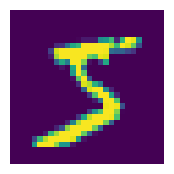

In [13]:
imshow(images[0])

In [22]:
from sklearn.model_selection import train_test_split
""
X_train, X_val, Y_train, Y_val = train_test_split(images, labels, test_size=0.37, random_state=seed)
len(X_train), len(X_val)

(126, 74)

In [23]:
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset

class MNIST(Dataset):
    def __init__(self, n_images, n_labels):
        self.n_images = n_images
        self.n_labels = n_labels
        
    def __len__(self):
        return len(self.n_images)
        
    def __getitem__(self, idx):
        
        img = self.n_images[idx]
        label = self.n_labels[idx]
        img = torch.from_numpy(img).float().unsqueeze(0) / 255.0
        label = torch.tensor(label, dtype=torch.long)
        
        return img, label

In [24]:
train_set = MNIST(X_train, Y_train)
val_set = MNIST(X_val, Y_val)

In [25]:
_batch_size = 8

train_dataloader = DataLoader(train_set, batch_size=_batch_size)
val_dataloader = DataLoader(val_set, batch_size=_batch_size)

### MLP model

In [26]:
sampleX, sampleY = next(iter(train_dataloader))
sampleX.shape, sampleY.shape

(torch.Size([8, 1, 28, 28]), torch.Size([8]))

In [27]:
def apply_kernel(img, kernel):
    # np-version
    #return np.sum(np.multiply(img, kernel))
    return torch.sum(img * kernel)

def custom_conv(batch, kernel, bias):
    bs, img_ch, img_w, img_h = batch.shape
    k_count, k_ch, k_w, k_h = kernel.shape
    
    if img_ch != k_ch:
        print('Different channels input')
        return
    
    w, h = img_w - k_w + 1, img_h - k_h + 1    
    
    # np-version
    #out = np.zeros((bs, k_count, w, h))
    out = torch.zeros((bs, k_count, w, h))
    
    for b_id in range(bs):
        current_sample = batch[b_id]

        for ch in range(k_count):
            current_kernel = kernel[ch]

            for row in range(h):
                for col in range(w):
                    window = current_sample[:, row : row + k_h, col : col + k_w]
                    out[b_id][ch][row][col] = apply_kernel(window, current_kernel)

    if bias is not None:
        out = out + bias.reshape(1, k_count, 1, 1)
                    
    return out

In [28]:
def max_pool(sample, k_size=2):
    
    batch_d, sample_d, sample_w, sample_h = sample.shape
    #out = np.zeros((batch_d, sample_d, sample_w // 2, sample_h // 2))
    out = torch.zeros((batch_d, sample_d, sample_w // 2, sample_h // 2))
    max_indices = torch.zeros_like(out, dtype=torch.long) # indexes where max val was, need for backprop
    
    for b in range(batch_d):
        for d in range(sample_d):
            for i in range(out.shape[-2]):
                for j in range(out.shape[-1]):

                    window = sample[b, d, i * 2 : i * 2 + 2, j * 2 : j * 2 + 2]
                    #out[b, d, i, j] = torch.amax(window)
                    
                    flat_idx = torch.argmax(window)  # flat индекс в окне
                    out[b, d, i, j] = window.reshape(-1)[flat_idx]
                    
                    max_indices[b, d, i, j] = flat_idx

    return out, max_indices

In [29]:
def custom_conv_backward(batch, kernel, dL_dout, bias=None):
    # batch: [B, C_in, H_in, W_in]
    # kernel: [C_out, C_in, K_h, K_w]
    # dL_dout: [B, C_out, H_out, W_out]

    B, C_in, H_in, W_in = batch.shape
    C_out, _, K_h, K_w = kernel.shape
    _, _, H_out, W_out = dL_dout.shape

    # ---- Градиент по bias ----
    dL_dbias = dL_dout.sum(dim=(0, 2, 3))  # [C_out]

    # ---- kernel grad (им2кол) ----
    # (B, C_in, H_in, W_in) -> (B, C_in*K_h*K_w, H_out*W_out)
    patches = batch.unfold(2, K_h, 1).unfold(3, K_w, 1)  # (B, C_in, H_out, W_out, K_h, K_w)
    patches = patches.permute(0,2,3,1,4,5).reshape(B, H_out*W_out, -1)  # (B, H_out*W_out, C_in*K_h*K_w)
    patches = patches.permute(0,2,1)  # (B, C_in*K_h*K_w, H_out*W_out)

    dL_dout_flat = dL_dout.reshape(B, C_out, -1)  # (B, C_out, H_out*W_out)

    # (C_out, C_in*K_h*K_w)
    grad_w = torch.einsum('bik,bjk->ij', dL_dout_flat, patches)  # sum по batch and spatial
    dL_dkernel = grad_w.reshape(C_out, C_in, K_h, K_w)

    # ---- batch grad (output grad -> input space свёртка "полная") ---
    # Используем готовую PyTorch функцию:
    dL_dbatch = torch.nn.grad.conv2d_input(
        (B, C_in, H_in, W_in), kernel, dL_dout
    )

    return dL_dbias, dL_dkernel, dL_dbatch

In [30]:
def max_pool_backward(dout, max_indices, input_shape, k_size=2):
    '''
    dout        : [B, D, H_out, W_out] — градиент по выходу maxpool
    max_indices : [B, D, H_out, W_out] — flat индексы максимумов (из форварда)
    input_shape : (B, D, H_in, W_in)   — shape входа до maxpool
    '''
    B, D, H_out, W_out = dout.shape
    H_in, W_in = input_shape[-2], input_shape[-1]
    din = torch.zeros((B, D, H_in, W_in), dtype=dout.dtype, device=dout.device)

    for b in range(B):
        for d in range(D):
            for i in range(H_out):
                for j in range(W_out):
                    idx = max_indices[b, d, i, j].item()
                    di = idx // k_size  # индекс внутри окна по высоте
                    dj = idx % k_size   # индекс внутри окна по ширине
                    in_i = i * k_size + di
                    in_j = j * k_size + dj
                    din[b, d, in_i, in_j] += dout[b, d, i, j]
    return din

In [31]:
def get_acc(logits, gt):
    probs = torch.softmax(logits, dim=1)
    pred_classes = torch.argmax(probs, dim=1)
    
    acc = (pred_classes == gt).sum().item() / len(gt)
    return acc

In [32]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [33]:
import torch.nn as nn
import torch.nn.functional as F

model = nn.Sequential(
    nn.Conv2d(1, 8, 3), # (8, 26, 26)
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(8, 16, 3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 32),
    nn.ReLU(),
    nn.Linear(32, 10)
)

model

Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=32, bias=True)
  (8): ReLU()
  (9): Linear(in_features=32, out_features=10, bias=True)
)

In [37]:
import torch.optim as optim

_lr = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=_lr)

In [111]:
import tqdm

current_eph = 0

for eph in range(current_eph, current_eph + 10):
    print(f" {'-' * 5} Epoch: {eph} {'-' * 5}")
    current_eph += 1
    t_losses = []
    t_acc = []
    
    for X, Y in train_dataloader:
        out = model(X)
        
        acc = get_acc(out, Y)
        t_acc.append(acc)
        
        loss = criterion(out, Y)
        t_losses.append(loss.item())
                
        optimizer.zero_grad()
        loss.backward()

        for param in model.parameters():
            if param.grad is not None:
                param.data += -_lr * param.grad

    loss_eph = sum(t_losses) / len(t_losses)    
    avg_acc = sum(t_acc) / len(t_acc)
    print(f'Train loss: {loss_eph:.4f} acc: {avg_acc:.4f}')
    
    v_losses = []
    v_acc = []

    for X, Y in val_dataloader:
        out = model(X)
        
        acc = get_acc(out, Y)
        v_acc.append(acc)
        
        loss = criterion(out, Y)
        v_losses.append(loss.item())

    loss_eph = sum(v_losses) / len(v_losses)    
    avg_acc = sum(v_acc) / len(v_acc)
    print(f'Val loss: {loss_eph:.4f} acc: {avg_acc:.4f}')

 ----- Epoch: 0 -----
Train loss: 2.3070 acc: 0.1042
Val loss: 2.2951 acc: 0.1000
 ----- Epoch: 1 -----
Train loss: 2.2637 acc: 0.1849
Val loss: 2.2569 acc: 0.1625
 ----- Epoch: 2 -----
Train loss: 2.1664 acc: 0.2734
Val loss: 2.0907 acc: 0.2875
 ----- Epoch: 3 -----
Train loss: 1.9029 acc: 0.3411
Val loss: 1.6123 acc: 0.5375
 ----- Epoch: 4 -----
Train loss: 1.4591 acc: 0.5286
Val loss: 1.3118 acc: 0.6000
 ----- Epoch: 5 -----
Train loss: 0.9666 acc: 0.6693
Val loss: 0.9394 acc: 0.7000
 ----- Epoch: 6 -----
Train loss: 0.7033 acc: 0.7578
Val loss: 0.7151 acc: 0.8000
 ----- Epoch: 7 -----
Train loss: 0.4964 acc: 0.8359
Val loss: 0.6029 acc: 0.8500
 ----- Epoch: 8 -----
Train loss: 0.3947 acc: 0.8828
Val loss: 0.5509 acc: 0.8875
 ----- Epoch: 9 -----
Train loss: 0.2670 acc: 0.9062
Val loss: 0.5114 acc: 0.8875


### Numpy model

In [ ]:
# import numpy as np

# def get_init_bounds(fan_in):
#     a = np.sqrt(5)
#     gain = np.sqrt(2.0 / (1 + a**2))

#     bound = gain * np.sqrt(3 / fan_in)
#     return bound

# conv1_bound = get_init_bounds(1 * 3 * 3)
# conv1W = np.random.uniform(-conv1_bound, conv1_bound, (8, 1, 3, 3))
# conv1b = np.random.uniform(-conv1_bound, conv1_bound, (8))

# conv2_bound = get_init_bounds(8 * 3 * 3)
# conv2W = np.random.uniform(-conv2_bound, conv2_bound, (16, 8, 3, 3))
# conv2b = np.random.uniform(-conv2_bound, conv2_bound, (16))

### Model from scratch with tensors

In [ ]:
conv1W = model[0].weight.clone().detach() # (8, 1, 3, 3) out_ch / in_ch / k_w / k_h
conv1b = model[0].bias.clone().detach() # (8)

conv2W = model[3].weight.clone().detach() # (16, 8, 3, 3)
conv2b = model[3].bias.clone().detach() # (16)

W1 = model[7].weight.clone().detach().T # (16 * 5 * 5, 32)
b1 = model[7].bias.clone().detach().T # (32)

W2 = model[9].weight.clone().detach().T # (32, 10)
b2 = model[9].bias.clone().detach().T # (10)

parameters = [conv1W, conv1b, conv2W, conv2b, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

sum([p.nelement() for p in parameters])

In [35]:
conv1W.shape, conv1b.shape, conv2W.shape, conv2b.shape, W1.shape, b1.shape, W2.shape, b2.shape

(torch.Size([8, 1, 3, 3]),
 torch.Size([8]),
 torch.Size([16, 8, 3, 3]),
 torch.Size([16]),
 torch.Size([400, 32]),
 torch.Size([32]),
 torch.Size([32, 10]),
 torch.Size([10]))

In [39]:
torch_out = model(sampleX)
torch_loss = criterion(torch_out, sampleY)

optimizer.zero_grad()
torch_loss.backward()

torch_loss.item()

2.248547077178955

In [40]:
c1 = custom_conv(sampleX, conv1W, conv1b)
r1 = torch.clamp(c1, min=0)
p1, p1_max_idx = max_pool(r1)

c2 = custom_conv(p1, conv2W, conv2b)
r2 = torch.clamp(c2, min=0)
p2, p2_max_idx = max_pool(r2)
flatten = p2.view((_batch_size, -1))

Z1 = flatten @ W1 + b1
A1 = torch.clamp(Z1, min=0)
logits = A1 @ W2 + b2

In [41]:
torch.allclose(torch_out, logits)

True

In [42]:
counts = logits.exp()
counts_sum = counts.sum(axis=1, keepdims=True)
probs = counts / counts_sum

logprobs = probs.log()
loss = -logprobs[range(_batch_size), sampleY].mean()
loss

tensor(2.2485, grad_fn=<NegBackward0>)

In [43]:
batch = logits.shape[0]
probs = torch.softmax(logits, dim=1)

one_hot = torch.zeros_like(probs)
one_hot[torch.arange(batch), sampleY] = 1

dlogits = (probs - one_hot) / _batch_size

dW2 = A1.T @ dlogits
db2 = dlogits.sum(axis=0)

cmp('w2', dW2.T, model[-1].weight)
cmp('b2', db2.T, model[-1].bias)

dA1 = dlogits @ W2.T
dZ1 = dA1 * (Z1 > 0).float()

dW1 = flatten.T @ dZ1
db1 = dZ1.sum(axis=0)

cmp('w2', dW1.T, model[-3].weight)
cmp('b2', db1.T, model[-3].bias)

dflatten = dZ1 @ W1.T

dp2 = dflatten.view(p2.shape)
dr2 = max_pool_backward(dp2, p2_max_idx, r2.shape)

dc2 = (dr2 * (c2 > 0))

dconv2b, dconv2W, dp1 = custom_conv_backward(p1, conv2W, dc2)
cmp('conv2W', dconv2W, model[3].weight)
cmp('conv2b', dconv2b, model[3].bias)

dr1 = max_pool_backward(dp1, p1_max_idx, r1.shape)
dc1 = (dr1 * (c1 > 0))

dconv1b, dconv1W, dp1 = custom_conv_backward(sampleX, conv1W, dc1)

cmp('conv1W', dconv1W, model[0].weight)
cmp('conv1b', dconv1b, model[0].bias)

w2              | exact: False | approximate: True  | maxdiff: 8.381903171539307e-09
b2              | exact: False | approximate: True  | maxdiff: 1.4901161193847656e-08
w2              | exact: False | approximate: True  | maxdiff: 1.1175870895385742e-08
b2              | exact: False | approximate: True  | maxdiff: 1.1175870895385742e-08
conv2W          | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
conv2b          | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
conv1W          | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
conv1b          | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09


# manual

In [44]:
import tqdm

current_eph = 0

for eph in range(current_eph, current_eph + 10):
    print(f" {'-' * 5} Epoch: {eph} {'-' * 5}")
    current_eph += 1
    t_losses = []
    t_acc = []
    
    for X, Y in tqdm.tqdm(train_dataloader):
        _batch_size = X.shape[0]
                
        # forward pass
        c1 = custom_conv(X, conv1W, conv1b)
        r1 = torch.clamp(c1, min=0)
        p1, p1_max_idx = max_pool(r1)

        c2 = custom_conv(p1, conv2W, conv2b)
        r2 = torch.clamp(c2, min=0)
        p2, p2_max_idx = max_pool(r2)
        flatten = p2.view((_batch_size, -1))

        Z1 = flatten @ W1 + b1
        A1 = torch.clamp(Z1, min=0)
        logits = A1 @ W2 + b2

        acc = get_acc(logits, Y)
        t_acc.append(acc)
        
        # loss
        counts = logits.exp()
        counts_sum = counts.sum(axis=1, keepdims=True)
        probs = counts / counts_sum

        logprobs = probs.log()
        loss = -logprobs[range(_batch_size), Y].mean()
        t_losses.append(loss)

        # backprop
        # backprop loss
        probs = torch.softmax(logits, dim=1)

        one_hot = torch.zeros_like(probs)
        one_hot[torch.arange(_batch_size), Y] = 1

        dlogits = (probs - one_hot) / _batch_size

        # backprop fc2
        dW2 = A1.T @ dlogits
        db2 = dlogits.sum(axis=0)
        
        # backprop non-linearity
        dA1 = dlogits @ W2.T
        dZ1 = dA1 * (Z1 > 0).float()

        # backprop fc1
        dW1 = flatten.T @ dZ1
        db1 = dZ1.sum(axis=0)
        
        # backprop flatten
        dflatten = dZ1 @ W1.T
        dp2 = dflatten.view(p2.shape)

        # backprop max_pool
        dr2 = max_pool_backward(dp2, p2_max_idx, r2.shape)

        # backprop ReLU with conv2
        dc2 = (dr2 * (c2 > 0))
        dconv2b, dconv2W, dp1 = custom_conv_backward(p1, conv2W, dc2)
        
        # backprop max_pool
        dr1 = max_pool_backward(dp1, p1_max_idx, r1.shape)

        # backprop ReLU with conv1
        dc1 = (dr1 * (c1 > 0))
        dconv1b, dconv1W, dp1 = custom_conv_backward(X, conv1W, dc1)

        # parameters = [conv1W, conv1b, conv2W, conv2b, W1, b1, W2, b2]
        grads = [dconv1W, dconv1b, dconv2W, dconv2b, dW1, db1, dW2, db2]

        for param, grad in zip(parameters, grads):
            param.data += -_lr * grad
          
    loss_eph = sum(t_losses) / len(t_losses)    
    avg_acc = sum(t_acc) / len(t_acc)
    print(f'Train loss: {loss_eph:.4f} acc: {avg_acc:.4f}')
    
    v_losses = []
    v_acc = []

    for X, Y in tqdm.tqdm(val_dataloader):
        _batch_size = X.shape[0]

        # forward pass
        c1 = custom_conv(X, conv1W, conv1b)
        r1 = torch.clamp(c1, min=0)
        p1, p1_max_idx = max_pool(r1)

        c2 = custom_conv(p1, conv2W, conv2b)
        r2 = torch.clamp(c2, min=0)
        p2, p2_max_idx = max_pool(r2)
        flatten = p2.view((_batch_size, -1))

        Z1 = flatten @ W1 + b1
        A1 = torch.clamp(Z1, min=0)
        logits = A1 @ W2 + b2

        acc = get_acc(logits, Y)
        v_acc.append(acc)

        # loss
        counts = logits.exp()
        counts_sum = counts.sum(axis=1, keepdims=True)
        probs = counts / counts_sum

        logprobs = probs.log()
        loss = -logprobs[range(_batch_size), Y].mean()
        v_losses.append(loss)

    loss_eph = sum(v_losses) / len(v_losses)    
    avg_acc = sum(v_acc) / len(v_acc)
    print(f'Val loss: {loss_eph:.4f} acc: {avg_acc:.4f}')

 ----- Epoch: 0 -----


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [01:40<00:00,  6.27s/it]


Train loss: 2.3070 acc: 0.1042


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:49<00:00,  4.91s/it]


Val loss: 2.2951 acc: 0.1000
 ----- Epoch: 1 -----


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [01:45<00:00,  6.57s/it]


Train loss: 2.2637 acc: 0.1849


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:02<00:00,  6.22s/it]


Val loss: 2.2569 acc: 0.1625
 ----- Epoch: 2 -----


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [02:00<00:00,  7.56s/it]


Train loss: 2.1664 acc: 0.2734


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.78s/it]


Val loss: 2.0907 acc: 0.2875
 ----- Epoch: 3 -----


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [02:06<00:00,  7.88s/it]


Train loss: 1.9029 acc: 0.3411


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:00<00:00,  6.03s/it]


Val loss: 1.6123 acc: 0.5375
 ----- Epoch: 4 -----


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [02:02<00:00,  7.65s/it]


Train loss: 1.4591 acc: 0.5286


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:02<00:00,  6.25s/it]


Val loss: 1.3118 acc: 0.6000
 ----- Epoch: 5 -----


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [02:06<00:00,  7.90s/it]


Train loss: 0.9666 acc: 0.6693


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:05<00:00,  6.52s/it]


Val loss: 0.9394 acc: 0.7000
 ----- Epoch: 6 -----


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [02:04<00:00,  7.76s/it]


Train loss: 0.7033 acc: 0.7578


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:01<00:00,  6.16s/it]


Val loss: 0.7151 acc: 0.8000
 ----- Epoch: 7 -----


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [02:02<00:00,  7.65s/it]


Train loss: 0.4964 acc: 0.8359


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:01<00:00,  6.17s/it]


Val loss: 0.6029 acc: 0.8500
 ----- Epoch: 8 -----


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [02:08<00:00,  8.03s/it]


Train loss: 0.3947 acc: 0.8828


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:00<00:00,  6.05s/it]


Val loss: 0.5509 acc: 0.8875
 ----- Epoch: 9 -----


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [01:59<00:00,  7.48s/it]


Train loss: 0.2670 acc: 0.9062


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:58<00:00,  5.85s/it]

Val loss: 0.5114 acc: 0.8875


### Inference

In [45]:
test_images = idx2numpy.convert_from_file('./mnist_dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels = idx2numpy.convert_from_file('./mnist_dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

len(test_images), len(test_labels)

(10000, 10000)

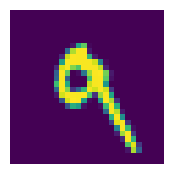

label=9


In [103]:
idx = 7
imshow(test_images[idx])
print(f'label={test_labels[idx]}')

In [104]:
sample = torch.tensor(test_images[idx]) / 255.0
sample = sample.unsqueeze(0).unsqueeze(0)
sample.shape

torch.Size([1, 1, 28, 28])

In [105]:
gt = torch.tensor(test_labels[idx]).unsqueeze(0)
gt.shape

torch.Size([1])

### Manual model inference

In [106]:
_batch_size = 1

In [107]:
# forward pass
c1 = custom_conv(sample, conv1W, conv1b)
r1 = torch.clamp(c1, min=0)
p1, p1_max_idx = max_pool(r1)

c2 = custom_conv(p1, conv2W, conv2b)
r2 = torch.clamp(c2, min=0)
p2, p2_max_idx = max_pool(r2)

flatten = p2.view((_batch_size, -1))

Z1 = flatten @ W1 + b1
A1 = torch.clamp(Z1, min=0)
logits = A1 @ W2 + b2

logits.shape

torch.Size([1, 10])

In [108]:
logits

tensor([[-7.1558,  1.1184, -3.5678, -0.1521,  2.1424, -1.3913, -0.6258, -2.2217,
          2.3161,  4.0951]], grad_fn=<AddBackward0>)

In [109]:
probs = torch.softmax(logits, dim=1)
probs

tensor([[9.3403e-06, 3.6629e-02, 3.3778e-04, 1.0281e-02, 1.0199e-01, 2.9776e-03,
         6.4019e-03, 1.2978e-03, 1.2132e-01, 7.1876e-01]],
       grad_fn=<SoftmaxBackward0>)

In [110]:
pred_class = torch.argmax(probs, dim=1)
pred_class

tensor([9])

### Torch model inference

In [112]:
torch_out = model(sample)
torch_out

tensor([[-7.1558,  1.1184, -3.5678, -0.1521,  2.1424, -1.3913, -0.6258, -2.2217,
          2.3160,  4.0951]], grad_fn=<AddmmBackward0>)

In [122]:
torch_probs = torch.softmax(torch_out, dim=1)
torch_probs

tensor([[9.3404e-06, 3.6629e-02, 3.3778e-04, 1.0281e-02, 1.0199e-01, 2.9776e-03,
         6.4020e-03, 1.2978e-03, 1.2132e-01, 7.1875e-01]],
       grad_fn=<SoftmaxBackward0>)

In [123]:
torch_pred_class = torch_probs.argmax(dim=1)
torch_pred_class

tensor([9])

#### Outputs after 10 epochs are nearly equal

In [115]:
logits - torch_out

tensor([[-4.7684e-07, -5.1260e-06, -5.7220e-06,  2.1756e-06, -1.1921e-06,
         -4.0531e-06, -6.9141e-06,  6.9141e-06,  3.0994e-06,  3.3379e-06]],
       grad_fn=<SubBackward0>)

In [124]:
probs - torch_probs

tensor([[-2.5466e-11, -2.6450e-07, -2.6776e-09, -2.7940e-09, -3.4273e-07,
         -1.7928e-08, -5.6345e-08,  5.8208e-09,  1.1921e-07,  8.3447e-07]],
       grad_fn=<SubBackward0>)

### Inference on test set

In [126]:
test_set = MNIST(test_images, test_labels)
test_dataloader = DataLoader(test_set, batch_size=_batch_size)

acc = []

for X, Y in test_dataloader:
    out = model(X)
    acc.append(get_acc(out, Y))
    
print(f'Test acc {sum(acc) / len(acc):.4f}')

Test acc 0.7801
